# Stock Analysis


# TODO
* # Candlestick plot


## Import libraries:

In [65]:
# Standard Python Libraries
from datetime import datetime, timedelta
import locale

# Third-party Dependencies
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
import plotly.colors

from IPython.display import display, HTML
from IPython.display import display_markdown

import pandas as pd
from pandas_datareader import data as pdr
import pandas_market_calendars as mcal

import numpy as np

## Get Stock Data

### Enter the stock symbol:

In [166]:
symbols = ['IVV', 'NOBL']

In [167]:
today = datetime.today()

start_date = today - timedelta(days=365*10)

stocks = {}
dividends = {}
for symbol in symbols:
    df_stock = pdr.get_data_yahoo(symbol, start_date.strftime("%m-%d-%Y"))
    df_actions = pdr.get_data_yahoo_actions(symbol, start_date.strftime("%m-%d-%Y"))
    df_stock = pd.DataFrame({symbol: df_stock['Close']})
    df_stock.index.name = 'Date'
    df_stock = df_stock.sort_values(by='Date')
    stocks[symbol] = df_stock
    
    # setup df_dividends
    df_dividends = df_actions[df_actions['action'] == 'DIVIDEND']

    df_dividends.index.name = 'Date'

    df_dividends = df_dividends.sort_values(by='Date')

    df_dividends['annual value'] = df_dividends['value'].rolling('365D').sum()

    df_dividends['annual yield'] = df_dividends['annual value'] / df_stock[symbol] * 100

    df_dividends.head()

    # ignore the annual yields for the dividends within the first year of data
    first_year = df_dividends.index[0].to_pydatetime() + timedelta(days=365)

    l = len(df_dividends[df_dividends.index < first_year]) - 1
    j = 0
    for i, d in df_dividends[df_dividends.index < first_year].iterrows():
        if j < l:
            df_dividends.loc[df_dividends.index == i, 'annual yield'] = np.nan
        j = j + 1
    
    dividends[symbol] = df_dividends

In [168]:
pct_change_dict = {}

for symbol in symbols:
    df_stock = stocks[symbol]
    pct_change = pd.DataFrame(index=df_stock.index, columns=['Daily Returns', 'Weekly Returns', 'Bi-weekly Returns', 'Semi-Annual Returns', 'Annual Returns'])

    pct_change['Daily Returns'] = df_stock.pct_change(periods=1)*100

    pct_change['Weekly Returns'] = df_stock.pct_change(periods=5)*100

    pct_change['Bi-weekly Returns'] = df_stock.pct_change(periods=10)*100

    pct_change['Semi-Annual Returns'] = df_stock.pct_change(periods=126)*100

    pct_change['Annual Returns'] = df_stock.pct_change(periods=252)*100

    pct_change_dict[symbol] = pct_change

### TODO:  color code the current line

## IVV Stats for Past Year

### Suggested purchase price for IVV:	458.67

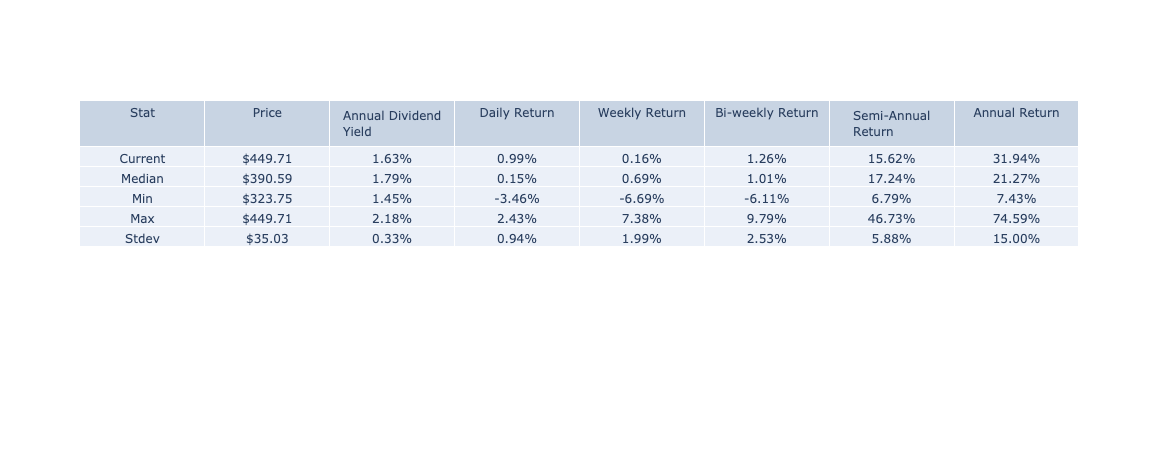

## NOBL Stats for Past Year

### Suggested purchase price for NOBL:	95.86

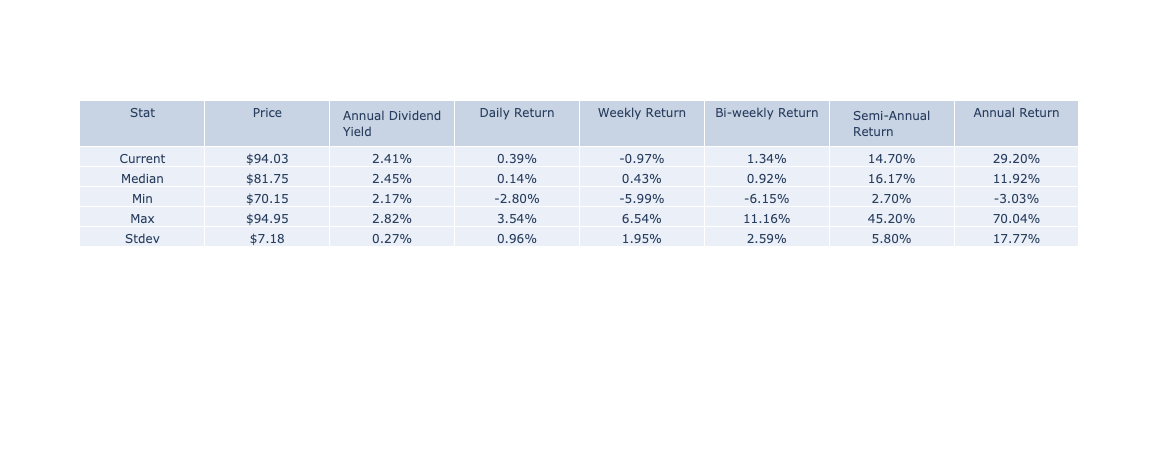

## IVV Stats for Past 5 Years

### Suggested purchase price for IVV:	460.30

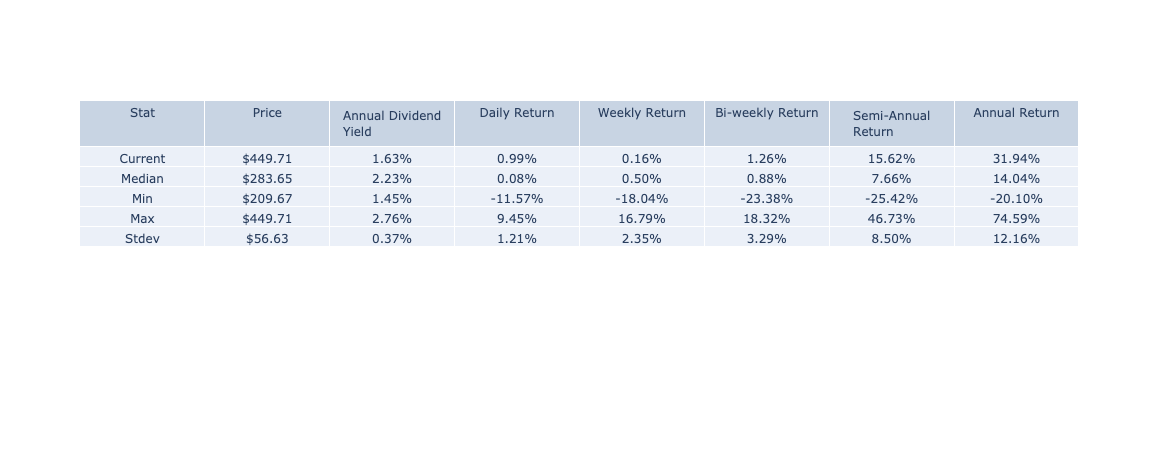

## NOBL Stats for Past 5 Years

### Suggested purchase price for NOBL:	96.24

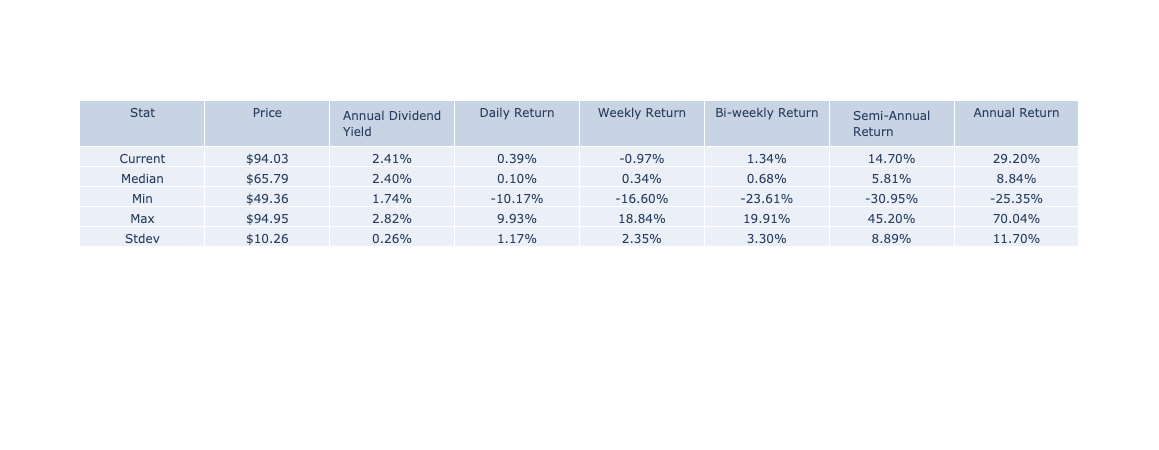

## IVV Stats for Past 10 Years

### Suggested purchase price for IVV:	459.39

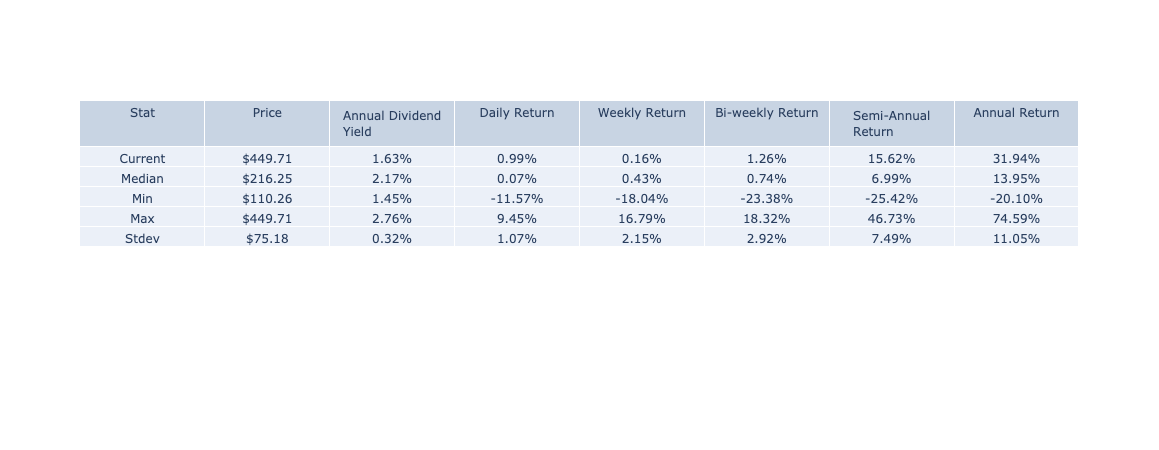

## NOBL Stats for Past 10 Years

### Suggested purchase price for NOBL:	96.03

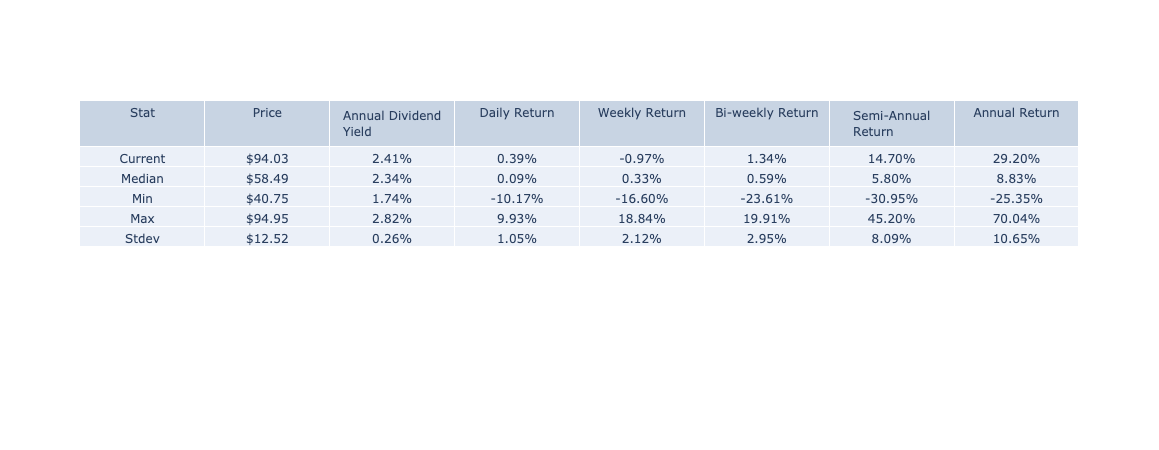

In [169]:
today = datetime.today()

header = {1: 'Stats for Past Year', 5: 'Stats for Past 5 Years', 10: 'Stats for Past 10 Years'}

years = [1, 5, 10]

for year in years: 
    start_date = today - timedelta(days=365*year)

    window = df_stocks[ df_stocks.index >= start_date ]

    c_names = ['Stat', 'Price', 'Annual Dividend Yield', 'Daily Return', 'Weekly Return', 'Bi-weekly Return', 'Semi-Annual Return', 'Annual Return']

    for symbol in symbols:
        display_markdown('## {} {}'.format(symbol, header[year]), raw=True)
        df_stock = stocks[symbol]
        window = df_stock[ df_stock.index >= start_date ]
        cur_row = ['Current']
        cur_row.extend(window.round(2).iloc[-1].values.tolist())    
        cur_row.append(dividends[symbol].round(2).iloc[-1]['annual yield'])
        cur_row.extend(pct_change_dict[symbol].round(2).iloc[-1].values.tolist())

        median_row = ['Median']
        median_row.extend(window.median().values)
        median_row.append(dividends[symbol].round(2).loc[dividends[symbol].index >= start_date, 'annual yield'].median())
        median_row.extend(pct_change_dict[symbol][pct_change_dict[symbol].index >= start_date].median().values)

        min_row = ['Min']
        min_row.extend(window.min().values)
        min_row.append(dividends[symbol].round(2).loc[dividends[symbol].index >= start_date, 'annual yield'].min())
        min_row.extend(pct_change_dict[symbol][pct_change_dict[symbol].index >= start_date].min().values)

        max_row = ['Max']
        max_row.extend(window.max().values)
        max_row.append(dividends[symbol].round(2).loc[dividends[symbol].index >= start_date, 'annual yield'].max())
        max_row.extend(pct_change_dict[symbol][pct_change_dict[symbol].index >= start_date].max().values)

        std_row = ['Stdev']
        std_row.extend(window.std().values)
        std_row.append(dividends[symbol].round(2).loc[dividends[symbol].index >= start_date, 'annual yield'].std())
        std_row.extend(pct_change_dict[symbol][pct_change_dict[symbol].index >= start_date].std().values)       

        stats = [cur_row, median_row, min_row, max_row, std_row]

        stats = pd.DataFrame(stats, columns=c_names)
        #stats = stats.set_index('Stat')

        std = pct_change_dict[symbol][pct_change_dict[symbol].index >= start_date]['Weekly Returns'].std()

        buy_plus = window.round(2).iloc[-1].values[0] * (1 + std/100)

        display_markdown('### Suggested purchase price for {}:\t{:0.2f}'.format(symbol, buy_plus), raw=True)

        print('\n')

        # display(HTML(stats.round(2).to_html()))
        portfolio_table = go.Table(
            header=dict(values=c_names),
            cells=dict(values=[ 
                stats['Stat'], 
                stats['Price'].map('${:,.2f}'.format), 
                stats['Annual Dividend Yield'].map('{:,.2f}%'.format), 
                stats['Daily Return'].map('{:,.2f}%'.format),
                stats['Weekly Return'].map('{:,.2f}%'.format),
                stats['Bi-weekly Return'].map('{:,.2f}%'.format),
                stats['Semi-Annual Return'].map('{:,.2f}%'.format),
                stats['Annual Return'].map('{:,.2f}%'.format)
            ])
        )

        fig = go.Figure(data=[portfolio_table])

        iplot(fig)

## Stats for Past Decade:

## IVV

## NOBL

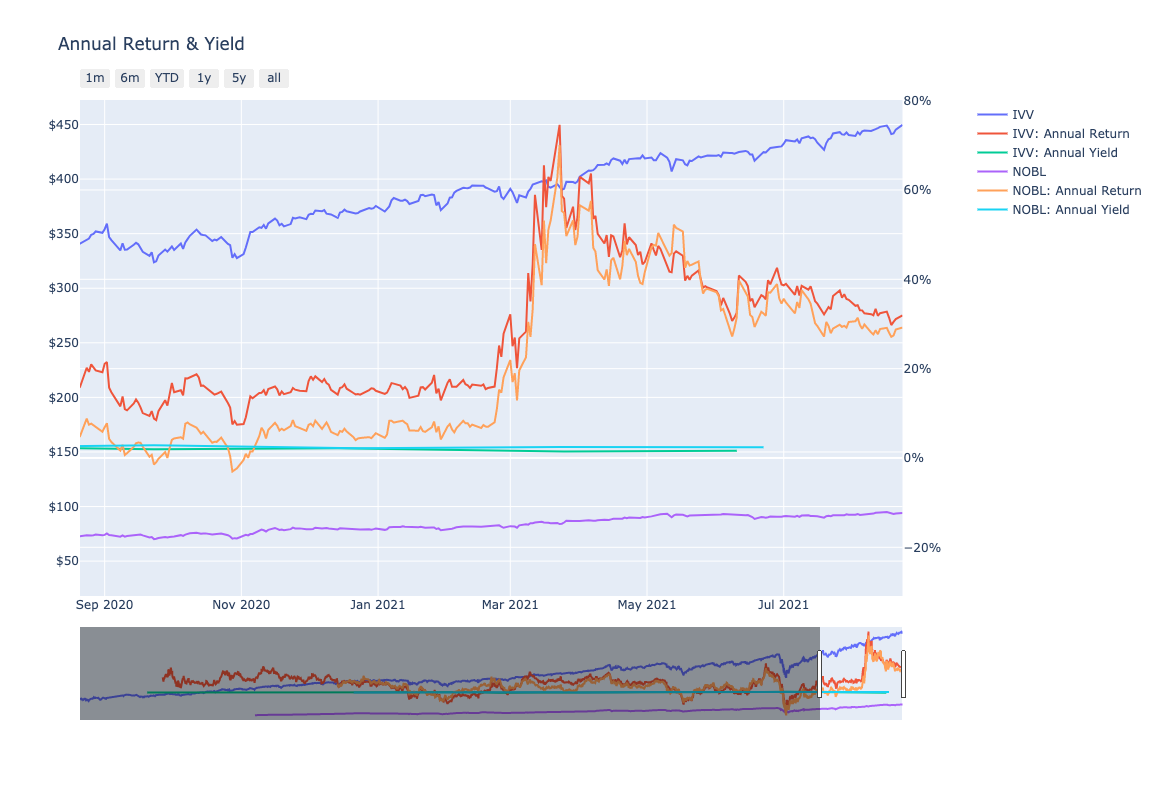

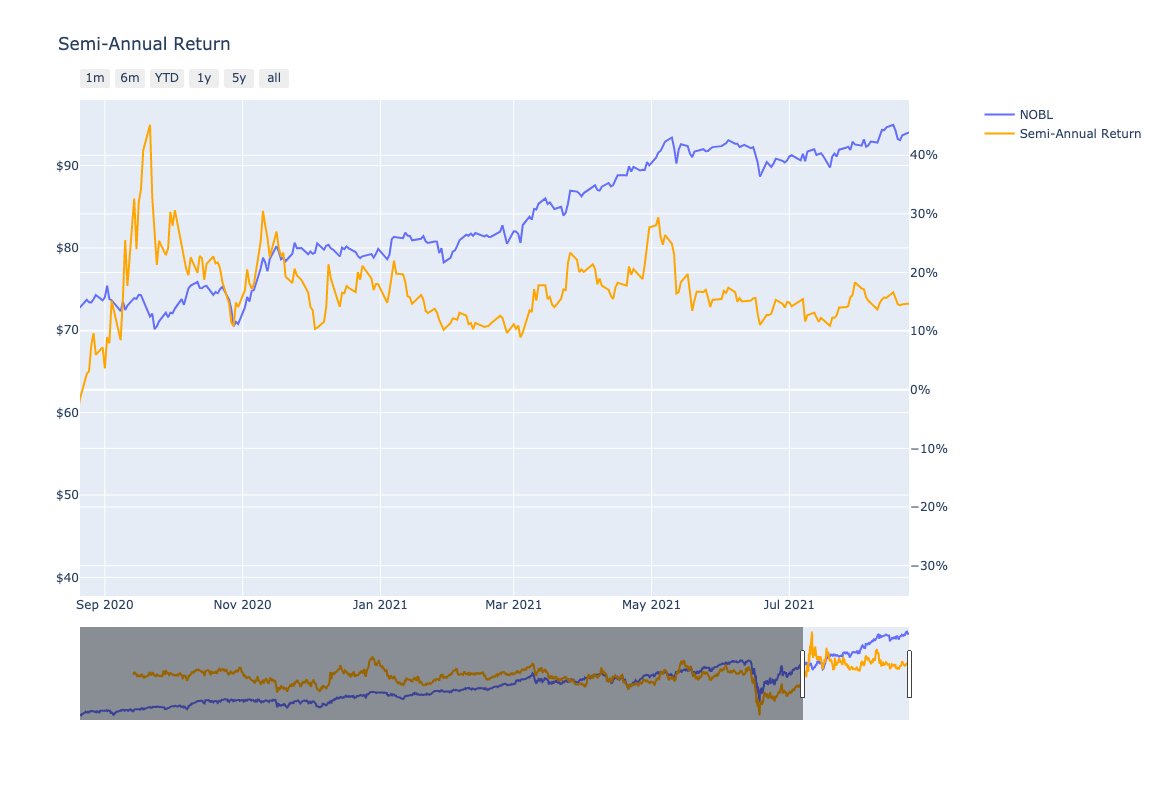

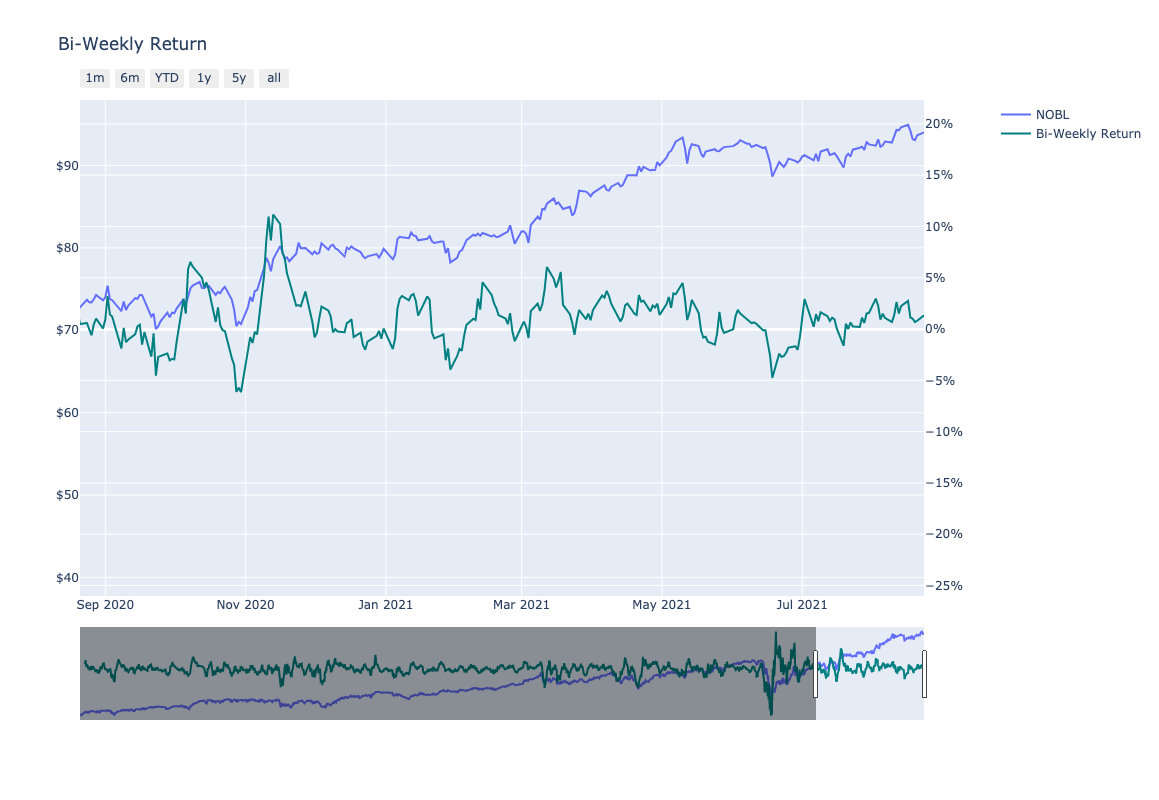

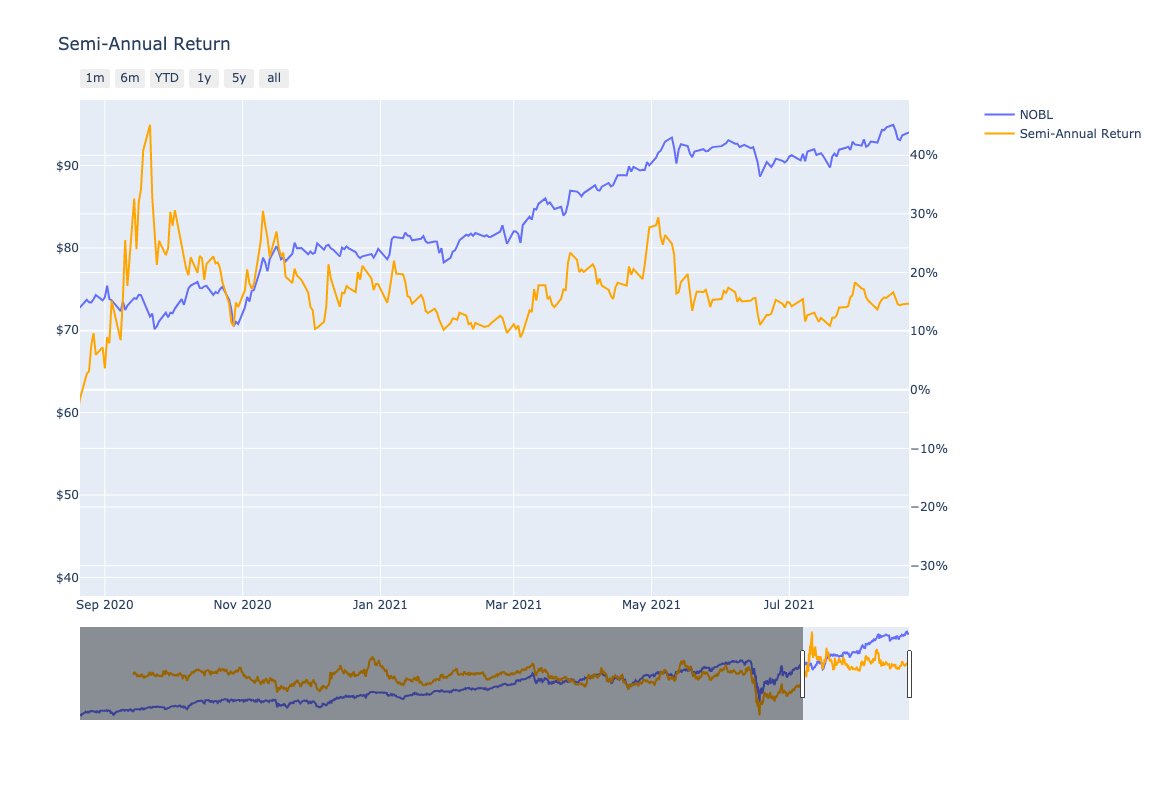

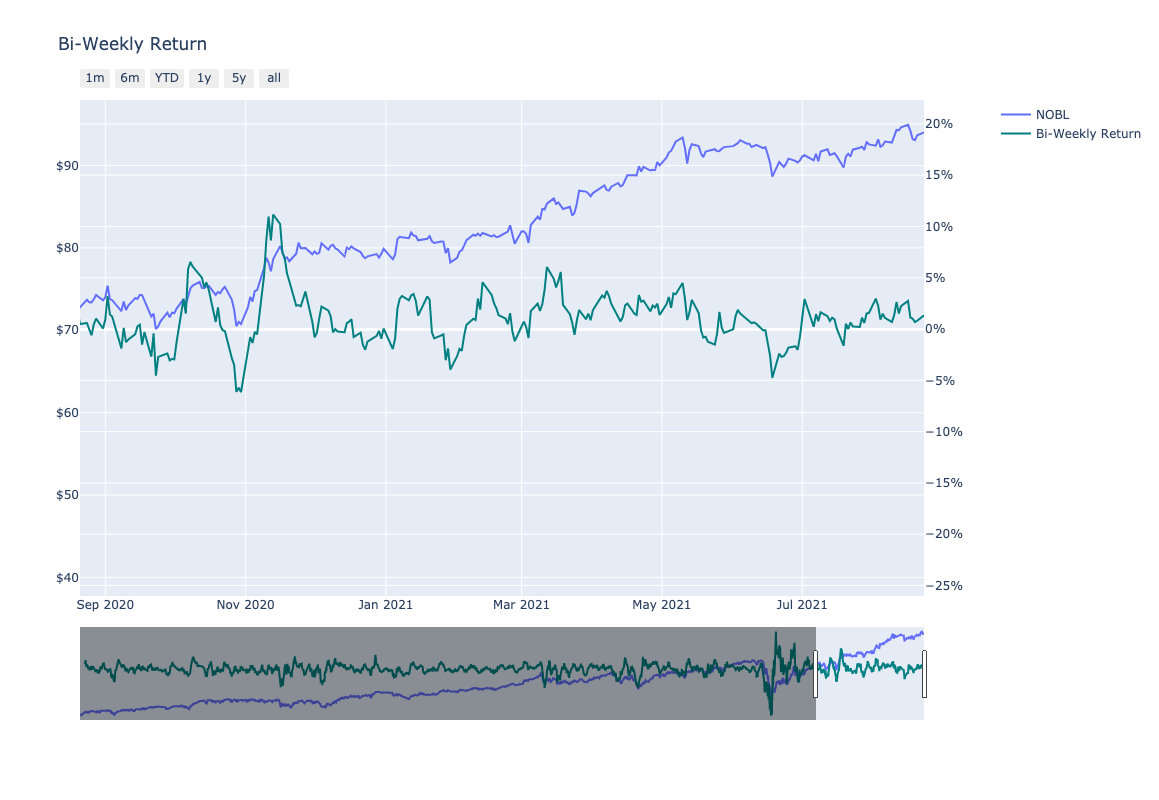

In [170]:
for symbol in symbols:
    display_markdown('## {}'.format(symbol), raw=True)
    df_stock = stocks[symbol]
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    color_mapper = {
        'stock' : 'blue',
        'dividend' : 'deepskyblue',
        'bi-weekly' : 'teal',
        'semi' : 'orange',
        'annual' : 'lightskyblue'
    }

    stock_curve = go.Scatter(
        x = df_stock.index,
        y = df_stock[symbol].round(2),
        hovertemplate = '%{x|%B %d, %Y}, %{y}',
        mode = 'lines',
        marker_color=color_mapper['stock'],
        name = symbol,
    )

    dividends_curve = go.Scatter(
        x = dividends[symbol].index,
        y = dividends[symbol]['annual yield'].round(2),
        hovertemplate = '%{x|%B %d, %Y}, %{y}%',
        mode = 'lines',
        marker_color=color_mapper['dividend'],
        name = 'Annual Yield',
    )

    bi_weekly_curve = go.Scatter(
        x = df_stock.index,
        y = pct_change_dict[symbol]['Bi-weekly Returns'].round(2),
        hovertemplate = '%{x|%B %d, %Y}, %{y}%',
        mode = 'lines',
        marker_color=color_mapper['bi-weekly'],
        name = 'Bi-Weekly Return',
    )

    semi_curve = go.Scatter(
        x = df_stock.index,
        y = pct_change_dict[symbol]['Semi-Annual Returns'].round(2),
        hovertemplate = '%{x|%B %d, %Y}, %{y}%',
        mode = 'lines',
        marker_color=color_mapper['semi'],
        name = 'Semi-Annual Return',
    )

    annual_curve = go.Scatter(
        x = df_stock.index,
        y = pct_change_dict[symbol]['Annual Returns'].round(2),
        hovertemplate = '%{x|%B %d, %Y}, %{y}%',
        mode = 'lines',
        marker_color=color_mapper['annual'],
        name = 'Annual Return',
    )

    height=800
    y_max = df_stock.max() + (df_stock.max()/100)*5

    y_range = dict(range=[0,y_max])

    end_date = df_stock.index[-1].to_pydatetime()
    start_date = end_date - timedelta(days=365)
    # TODO error check this if there is less than 1 year of history
    start_date = df_stock[ df_stock.index <= start_date ].index[-1].to_pydatetime()

    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    initial_range = [start_date, end_date]

    # annual graph
    fig = make_subplots(specs=[[{"secondary_y": True}]])

for symbol in symbols:    
    df_stock = stocks[symbol]
    
    stock_curve = go.Scatter(
        x = df_stock.index,
        y = df_stock[symbol].round(2),
        hovertemplate = '%{x|%B %d, %Y}, %{y}',
        mode = 'lines',
        #marker_color=color_mapper['stock'],
        name = symbol,
    )

    dividends_curve = go.Scatter(
        x = dividends[symbol].index,
        y = dividends[symbol]['annual yield'].round(2),
        hovertemplate = '%{x|%B %d, %Y}, %{y}%',
        mode = 'lines',
        #marker_color=color_mapper['dividend'],
        name = '{}: Annual Yield'.format(symbol),
    )
    
    annual_curve = go.Scatter(
        x = df_stock.index,
        y = pct_change_dict[symbol]['Annual Returns'].round(2),
        hovertemplate = '%{x|%B %d, %Y}, %{y}%',
        mode = 'lines',
        #marker_color=color_mapper['annual'],
        name = '{}: Annual Return'.format(symbol),
    )    
    
    fig.add_trace(
        stock_curve,
        secondary_y=False,
    )
    fig.add_trace(
        annual_curve,
        secondary_y=True,
    )
    fig.add_trace(
        dividends_curve,
        secondary_y=True,
    )
fig.update_layout(
    title = 'Annual Return & Yield',
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.', 
    height=height, 
    yaxis=y_range,
    yaxis2=dict(ticksuffix='%'),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date",
        range=initial_range
    )
)
iplot(fig)

for symbol in symbols:
    # semi annual graph
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        stock_curve,
        secondary_y=False,
    )
    fig.add_trace(
        semi_curve,
        secondary_y=True,
    )
    fig.update_layout(
        title = 'Semi-Annual Return',
        yaxis_tickprefix = '$', 
        yaxis_tickformat = ',.', 
        height=height, 
        yaxis=y_range,
        yaxis2=dict(ticksuffix='%'),
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="YTD",
                         step="year",
                         stepmode="todate"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=5,
                         label="5y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date",
            range=initial_range
        )
    )
    iplot(fig)

    # bi-weekly graph
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        stock_curve,
        secondary_y=False,
    )
    fig.add_trace(
        bi_weekly_curve,
        secondary_y=True,
    )
    fig.update_layout(
        title = 'Bi-Weekly Return',
        yaxis_tickprefix = '$', 
        yaxis_tickformat = ',.', 
        height=height, 
        yaxis=y_range,
        yaxis2=dict(ticksuffix='%'),
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="YTD",
                         step="year",
                         stepmode="todate"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=5,
                         label="5y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date",
            range=initial_range
        )
    )
    iplot(fig)